# Weekly Assignment 3

We import all the necessary packages first.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np

/home/arturo/.local/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Load the data and store the columns in new variables.

In [2]:
data = pd.read_csv("diet_and_atp.tsv", header=[0], sep="\t")
P = data["Protein"]
C = data["Carbohydrates"]
F = data["Fat"]
A = data["ATP"]

Exploratory data analysis

In [3]:
print("Protein max. - min.:"+"%s - %s"  %(P.max(),P.min()))
print("Carbohydrates max. - min.:"+"%s - %s" % (C.max(),C.min()))
print("Fat max. - min: "+"%s - %s" % (F.max(),F.min()))
print("Protein mean = %.3f" %(P.mean()))
print("Carbohydrates mean = %.3f" %(C.mean()))
print("Fat mean = %.3f" %(F.mean()))

Protein max. - min.:2.1 - 0.0
Carbohydrates max. - min.:7.0 - 0.03
Fat max. - min: 0.35 - 0.0
Protein mean = 1.045
Carbohydrates mean = 3.707
Fat mean = 0.163


# Create the model with the required variables.

The intake of each macronutrient is randomly assigned to each patient and follows a uniform distribution between 0 and 1, as stated in the exercise.

The coefficients for each macronutrient follow a normal distribution. This is an assumtion based on the biological nature of the experiment, and also a slightly informed guess. We know the product of this value and the intake of the macronutrients should give a number similar to the observations for the measurements, that is, the data in "diet_and_atp.tsv". For that reason, we put the expected value (or mean) of this coefficients in the mean of the macronutrient, multiplied by 2. I use a standard deviation of 20 because we do not expect the value to fluctuate a lot, since the macronutrient intake can only vary between 0 and 1, and the macronutrient ranges are not too wide (as seen in the previous block).

The measurements (prot_out, carb_out and fat_out) are also following a normal distribution which mean is equal to the product of the coefficient and the intake of a given macronutrient. The standard deviation is that of the observed data.

The ATP measurement follows a normal distribution which mean is equal to the sum of the previous measurements. As a whole, this model has an undetermined error that ranges between 0 and 100 with uniform probability, and this is an uninformed guess.

In [4]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100) #error term
    
    prot_intake = pm.Uniform("prot_intake",0,1) #protein given to the patients
    carb_intake = pm.Uniform("carb_intake",0,1) #carbohydrates given to the patients 
    fat_intake = pm.Uniform("fat_intake",0,1) #fat given to the patients
    
    p = pm.Normal("p", mu = P.mean()*2, sigma = 20) #protein coefficient
    c = pm.Normal("c", mu = C.mean()*2, sigma = 20) #carbohydrate coefficient
    f = pm.Normal("f", mu = F.mean()*2, sigma = 20) #fat coefficient
    
    prot_out = pm.Normal("Prot", mu = p*prot_intake, sigma = P.std(), observed = P) #protein measurements
    carb_out = pm.Normal("Carbs", mu = c*carb_intake, sigma = C.std(), observed = C) #carbohydrates measurements
    fat_out = pm.Normal("Fats", mu = f*fat_intake, sigma = F.std(), observed = F) #fat measurements
    
    atp_out = pm.Normal("ATP", mu = prot_out+carb_out+fat_out, sigma = std, observed = A) #atp measurements
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [f]
>Metropolis: [c]
>Metropolis: [p]
>Metropolis: [fat_intake]
>Metropolis: [carb_intake]
>Metropolis: [prot_intake]
>Metropolis: [std]
Sampling 2 chains, 0 divergences: 100%|██████████| 201000/201000 [2:15:18<00:00, 24.76draws/s]  
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


# Results

/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2830046d8>,
      dtype=object)

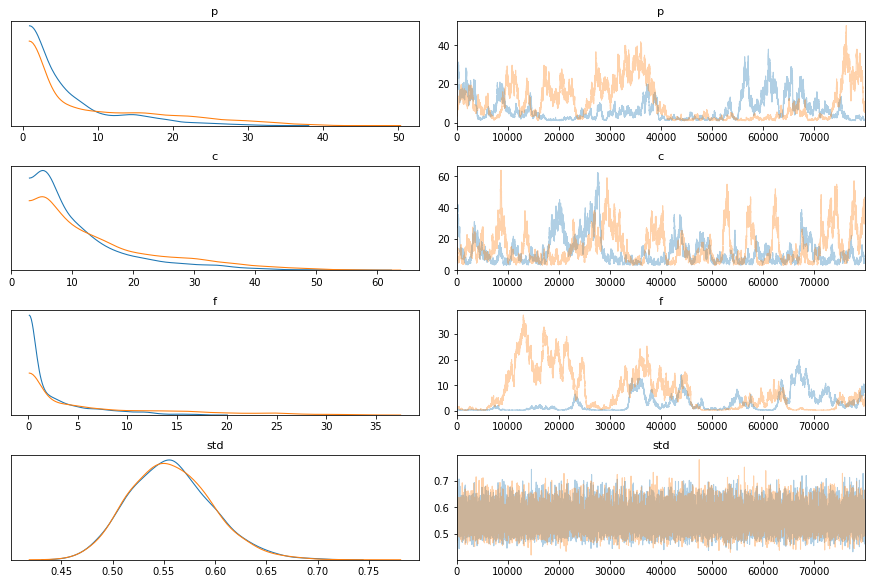

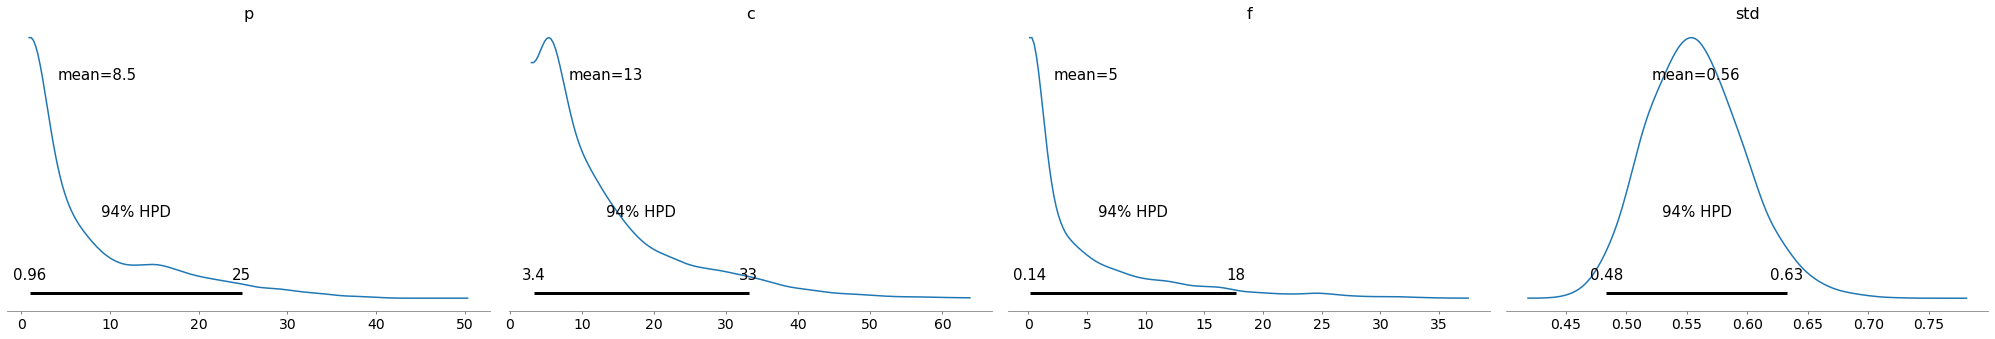

In [5]:
pm.plots.traceplot(burned_trace, var_names=["p", "c", "f", "std"])
pm.plot_posterior(data=burned_trace, var_names=["p", "c", "f", "std"])

# Comentary on the results
Here we see that chains do not follow the same steps mostly. In fact, there are big fluctiations for the values of every parameter, although most of the time they tend to stay in the range between 0 and 10.
In the case of proteins, the mean of the posterior distribution is 8.5, and the 95% confidence interval is between 0.96 and 25.
In the case of carbohydrates, the mean of the posterior distribution is 13, and the 95% confidence interval is between 3.4 and 33.
In the case of fat, the mean of the posterior distribution is 5, and the 95% confidence interval is between 0.14 and 18.

The posterior distributions do not resemble a normal distribution for any of the parameters. This would mean that our initial guess is mostly wrong. The ranges for every parameter are very wide, which doesn't tell us much about the real value of the parameters. I wouldn't be confident in applying the means of these distributions as parameters for prediction of ATP production.

All of this points to the fact that the explored probability distribution has many local minima and various combinations of the three parameters result in low error, but none of these combinations is specially good. That is why there is no convergence.